In [1]:
import pandas as pd
import numpy as np
import os
import json

In [2]:
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
# pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = 9, 4

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from codes.plotting_funcs import plot_features_dists
from codes.plotting_funcs import plot_heatmap

In [7]:
from tqdm.notebook import tqdm
from IPython.display import display
pd.options.display.max_columns = 100

In [8]:
SEED = 10

# Препроцессинг: обработка выборки

В этом ноутбуке я очищаю выборку и работаю с признаками по отдельности, практически без учета зависимостей и корреляций.

Основная задача на данный момент -- определить типы признаков, исследовать распределения, удалить ненужные признаки (провести первичный отбор); имеет место и преобразование признаков (например, логарифмирование).

# Первый взгляд на данные

В первую очередь стоит посмотреть на данные: определить типы, сбалансированность выборки, количество пропусков и т.д.

In [9]:
def display_df(df, n=3):
    display(df.head(n))
    display(df.tail(n))    

In [10]:
df = pd.read_csv('data/churn_dataset.csv').drop_duplicates()
display_df(df)

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.0,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.0,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,NaN,7.0,6.0,WC,1.0,1.0,NaN,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.0,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,NaN,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0,1000003


,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0,31,1,1,U,DA,N,1271,9336.0,1114.91,1055.93,9234.0,1238,55.58,486.00,65.16,662,85,61,712.0,88.0,72.0,U,SOUTHWEST AREA,Y,N,199.98999,2.0,2.0,WCMB,0.0,0.0,NaN,NaN,NaN,B,1.0,M,9.0,NaN,NaN,NaN,0.0,U,Y,Y,U,U,U,N,433.0,1099998
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.666667,0.0,0.666667,0.0,117.333333,0.0,550.666667,0.333333,327.000000,0.0,417.0,0.333333,1.333333,1.333333,0.106667,235.333333,1.000000,564.233333,1.656667,330.89,55.000000,62.896667,16.666667,32.883333,442.333333,0.333333,641.23,1.656667,167.333333,0.0,253.893333,0.0,19.333333,551.000000,417.333333,0.0,0.0,0,25,1,1,U,EA,N,10082,20784.0,2669.20,2593.26,20488.0,9921,123.49,975.62,472.43,1031,450,148,943.0,433.0,165.0,U,SOUTHWEST AREA,Y,N,149.98999,7.0,5.0,WCMB,0.0,0.0,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN,NaN,NaN,0.0,S,U,U,U,U,U,N,75.0,1099999
99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.666667,0.0,0.666667,0.0,19.333333,0.0,155.666667,0.000000,1.333333,0.0,130.0,0.000000,0.666667,0.666667,0.183333,1.333333,3.666667,164.436667,0.000000,0.00,4.666667,7.110000,0.000000,0.000000,99.000000,0.000000,133.69,0.000000,32.333333,0.0,30.746667,0.0,6.333333,155.666667,130.000000,0.0,0.0,1,25,1,1,U,B,N,1303,2355.0,956.47,885.94,2225.0,1231,46.63,117.11,64.79,105,60,51,111.0,64.0,51.0,S,LOS ANGELES AREA,Y,N,149.98999,3.0,2.0,WCMB,0.0,0.0,NaN,2.0,S,A,2.0,M,4.0,NaN,NaN,A,0.0,H,U,U,U,U,U,N,5.0,1100000


Выведем общую информацию о таблице.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

Имеется достаточно много пропусков, обработаем их позже. Сейчас посмотрим, есть ли столбцы с единственным уникальным значением.

In [12]:
uniqs = []
for column in list(df.columns):
    uniqs.append(len(df[column].unique()))
uniqs_df = pd.DataFrame(index= list(df.columns), columns=['quantity'], data=uniqs)
len(uniqs_df[uniqs_df.quantity == 1])

0

Посмотрим на столбцы, уникальных значений которых не так много.

In [13]:
nunique_df = pd.DataFrame(df.nunique(), columns=['quantity'])
nunique_df[nunique_df.quantity < 10]

,quantity
churn,2
new_cell,3
asl_flag,2
prizm_social_one,5
dualband,4
refurb_new,2
hnd_webcap,3
truck,2
rv,2
ownrent,2


In [14]:
binary = list(nunique_df[nunique_df.quantity == 2].index)
del nunique_df, uniqs_df, uniqs

Сразу же выделяются бинарные признаки.

## Разбиение признаков по типам

Определим, какие признаки числовые *(отображают количество чего-то)* и какие категориальные.

Категориальные признаки делятся на порядковые и номинальные *(неподрядковые)*. Кроме того, некоторые порядковые категориальные признаки можно принимать за дискретные числовые. Не имея на руках описания всех признаков, я буду действовать по большей степени интуитивно, приводя свои рассуждения.

Важно определить категориальные признаки в целочисленном виде. Часто бывает такое, что при считывании у таких признаков тип меняется на дробный, что может сильно затруднять анализ. Как правило, в них могут встречаться пропуски, и тогда происходит автоматический каст к дробному числу.

In [15]:
nums = set(df.select_dtypes(include='number').columns.tolist()) - set(binary)
cats = set(df.select_dtypes(object).columns.tolist()) - set(binary)

nums, cats = list(nums), list(cats)
assert len(cats) + len(nums) + len(binary) == df.shape[1]

In [16]:
ints = []
for col in df[nums].columns:
    values = df[col].fillna(0).values
    if np.all(values == values.astype(int)):
        ints += [col]

In [17]:
floats = list(np.setdiff1d(nums, ints))
assert len(ints) + len(floats) + len(cats) + len(binary) == df.shape[1]
del nums

In [18]:
# Категориальные признаки приводим к верхнему регистру
for cat in cats:
    df[cat] = df[cat].str.upper()

## Разделение выборки

Я предпочитаю разбивать выборку на тренировочную, валидационную и тестовую в соотношении 6:2:2. Для начала сделаем разбиение на train и test, а уже в разделе о построении моделей добавим валидационную.

Посмотрим на сбалансированность выборки.

In [19]:
df.churn.value_counts()

0    50438
1    49562
Name: churn, dtype: int64

В целом выборка является сбалансированной, так как долевое сооотношение классов можно считать одинаковым. Однако при разделении выборки на traint-test все равно лучше использовать стратификацию по таргету.

In [20]:
df_train, df_test, y_train, y_test = train_test_split(df, df.churn, test_size=0.2, random_state=SEED, stratify=df.churn)

# Предобработка данных

Прежде чем переходить к EDA, данные следует обработать: заполнить (в частном порядке) пропуски, детектировать выбросы, привести признаки к удобной форме (например, логарифмировать).

## Исследование целочисленных признаков
Раннее было проделано разделение признаков по типу данных, сейчас же я хочу разделить признаки целочисленного типа на количественные и категориальные.

In [21]:
print(ints)

['Customer_ID', 'numbcars', 'avg6qty', 'actvsubs', 'totcalls', 'adults', 'uniqsubs', 'models', 'adjqty', 'phones', 'avg3mou', 'months', 'avg6mou', 'lor', 'income', 'avg6rev', 'avg3qty', 'eqpdays', 'avg3rev']


Очевидно, что `Customer_ID` не является признаком -- он несет в себе информацию о пользователе. `churn` -- наш таргет, его нельзя рассматривать как признак априори.

In [22]:
df_train.drop(columns=['Customer_ID'], inplace=True)
df_test.drop(columns=['Customer_ID'], inplace=True)

trunc_ints = list(set(ints) - set(['churn', 'Customer_ID']))
binary = list(set(binary) - set(['churn']))
tmp_df = df_train[trunc_ints]

Давайте выведем некоторые данные об этой таблице.

In [23]:
tmp_df.describe()

,months,totcalls,avg6mou,avg6rev,adults,numbcars,lor,uniqsubs,income,avg6qty,models,avg3qty,eqpdays,actvsubs,adjqty,phones,avg3rev,avg3mou
count,80000.000000,80000.000000,77722.000000,77722.000000,61449.000000,40423.000000,55688.000000,80000.000000,59503.000000,77722.000000,79999.000000,80000.000000,79999.000000,80000.000000,80000.000000,79999.000000,80000.000000,80000.000000
mean,18.845400,2881.411375,509.218728,58.691246,2.530570,1.566583,6.172263,1.549737,5.779288,178.196096,1.546732,180.234400,391.713471,1.359088,2840.548800,1.788985,59.225938,519.338088
std,9.668516,3831.949874,494.196597,40.447947,1.453824,0.623984,4.736698,1.120554,2.179804,181.266247,0.899463,191.183708,256.194233,0.661399,3797.583512,1.314849,46.330514,530.338045
min,6.000000,0.000000,0.000000,-2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,11.000000,891.000000,163.000000,34.000000,1.000000,1.000000,2.000000,1.000000,4.000000,59.000000,1.000000,55.000000,211.000000,1.000000,871.000000,1.000000,33.000000,151.000000
50%,16.000000,1820.000000,363.000000,50.000000,2.000000,1.000000,5.000000,1.000000,6.000000,127.000000,1.000000,126.000000,342.000000,1.000000,1787.000000,1.000000,48.000000,358.000000
75%,24.000000,3489.000000,697.750000,71.000000,3.000000,2.000000,9.000000,2.000000,7.000000,237.000000,2.000000,240.000000,530.000000,2.000000,3439.000000,2.000000,71.000000,712.000000
max,61.000000,98874.000000,7217.000000,866.000000,6.000000,3.000000,15.000000,196.000000,9.000000,2887.000000,16.000000,3261.000000,1823.000000,53.000000,98705.000000,28.000000,1593.000000,7716.000000


Заметим, что некоторые значения выглядят как выбросы. Например, у признака `eqpdays` минимальное значение -5, а у `avg6rev` -2. Заменим эти значения нулями.

In [24]:
len(tmp_df[tmp_df['eqpdays'] <= 0]), len(tmp_df[tmp_df['avg6rev'] <= 0])

(144, 2)

In [25]:
df_train.loc[df_train.eqpdays < 0, 'eqpdays'] = 0
df_train.loc[df_train.avg6rev < 0, 'avg6rev'] = 0
df_train.loc[df_train.avg3rev < 0, 'avg3rev'] = 0
df_test.loc[df_test.eqpdays < 0, 'eqpdays'] = 0
df_test.loc[df_test.avg6rev < 0, 'avg6rev'] = 0
df_test.loc[df_test.avg3rev < 0, 'avg3rev'] = 0

Уже можно сделать некоторые выводы.

* Во-первых, признаки `months`, `uniqsubs`, `actvsubs`, `totcalls`, `phones`, `models`, `adults`, `numbcars` отображают количество, значит, они числовые;
* Во-вторых, такие признаки как `avg3mou`, `avg3qty`, `avg3rev`, `avg6mou`, `avg3qty`, `avg6rev` относятся к числовым, так как судя по именованиям они являются какими-то усредненными статистиками, и в целом их можно отнести к разряду непрерывных числовых признаков несмотря на целочисленный тип. Отрисовав их распределения, мы в этом убедимся;
* Про остальные признаки нельзя сказать наверняка, рассмотрим их отдельно.

Отдельно отметим, что для большинства признаков разница между значением третьей квантили и максимального значения довольно велика, что может говорить о выбросах. Прежде чем удалять, лучше сначала посмотреть на распределения признаков. Предположительно числовые признаки стоит логарифмировать, тем самым мы сразу сможем понять, есть ли в них выбросы.

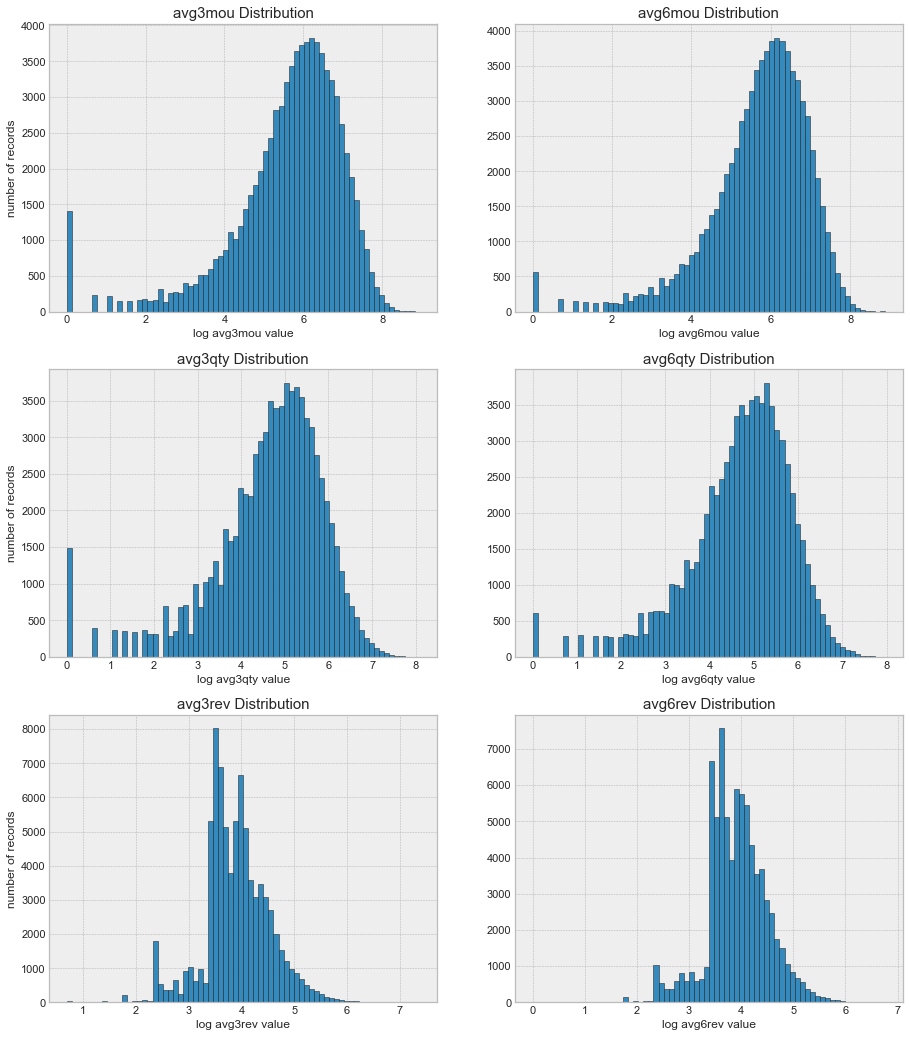

In [26]:
plot_features_dists(df_train, ['avg3mou', 'avg6mou', 'avg3qty', 'avg6qty', 'avg3rev', 'avg6rev'],
        log=True)

Я вывел распределения попарно и, как видно на картинке, различий практически нет. Значит, можно избавиться от некоторых признаков, что поможет нам избежать проблемы мультиколлинеарности. Обоснование заключается в том, что, вероятно, эти признаки отображают какую-либо статистику за последние три или шесть месяцев. Для предсказания оттока важны свежие данные, а брать данные полугодичной давности -- не очень разумно. С другой стороны, можно вывести новую статистику, которая описывает изменение (возможно, активности пользователя) за промежуток времени.

In [27]:
df_train['log1p_avg36mou_abs_diff'] = np.log1p(np.abs(df_train.avg3mou - df_train.avg6mou))
df_train['log1p_avg36rev_abs_diff'] = np.log1p(np.abs(df_train.avg3rev - df_train.avg6rev))
df_train['log1p_avg36qty_abs_diff'] = np.log1p(np.abs(df_train.avg3qty - df_train.avg6qty))

df_test['log1p_avg36mou_abs_diff'] = np.log1p(np.abs(df_test.avg3mou - df_test.avg6mou))
df_test['log1p_avg36rev_abs_diff'] = np.log1p(np.abs(df_test.avg3rev - df_test.avg6rev))
df_test['log1p_avg36qty_abs_diff'] = np.log1p(np.abs(df_test.avg3qty - df_test.avg6qty))

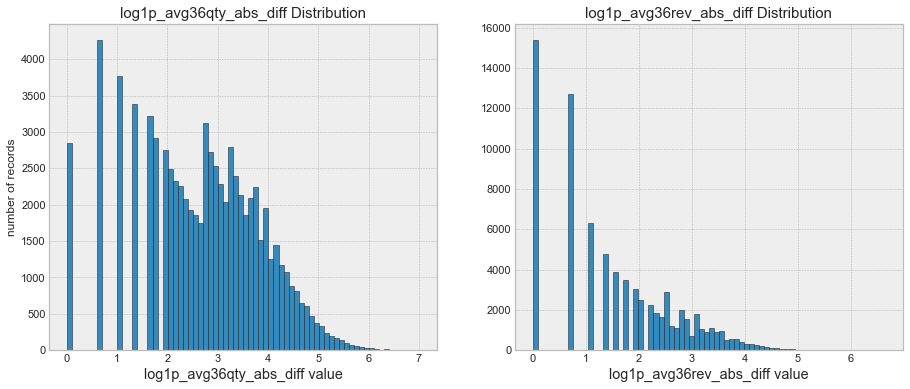

In [28]:
plot_features_dists(df_train, ['log1p_avg36qty_abs_diff', 'log1p_avg36rev_abs_diff'])

Распределения этих признаков уже могут намекать на некоторые выводы. Тем не менее, пока что оставим исходные признаки. Часто, например, в задачах кредитного скоринга бывает полезным брать признаки из разных промежутков времени. С таким я еще не сталкивался на своей практике, поэтому преждевременных выводов делать не могу. Однако проблема мультиколлинеарности действительно имеем мысто быть.

Заметим, что *в предположении отсутствия выбросов* распределения `avg3rev`, `avg6rev` похожи на бимодальные (распределения с двумя модами), либо же их можно расценивать как смесь двух распределений и, применив EM-алгоритм, получить новый признак о принадлежности объекта тому или иному распределению. В данном задании я не буду этого делать, однако считаю важным обозначить этот момент.

Выведем и графики распределений признаков первой категории.

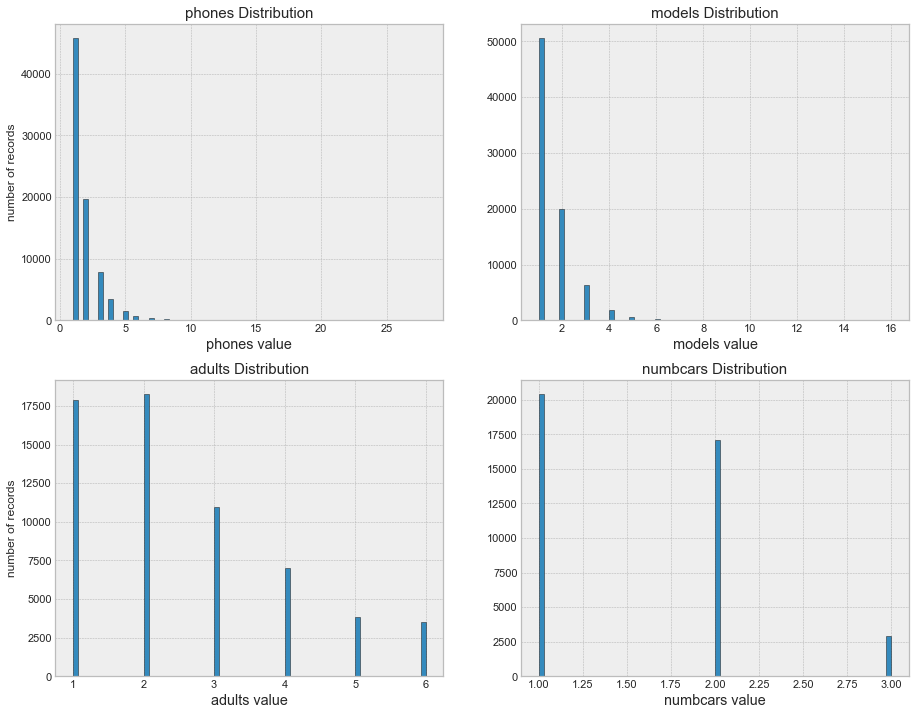

In [29]:
plot_features_dists(df_train, ['phones', 'models', 'adults', 'numbcars'])

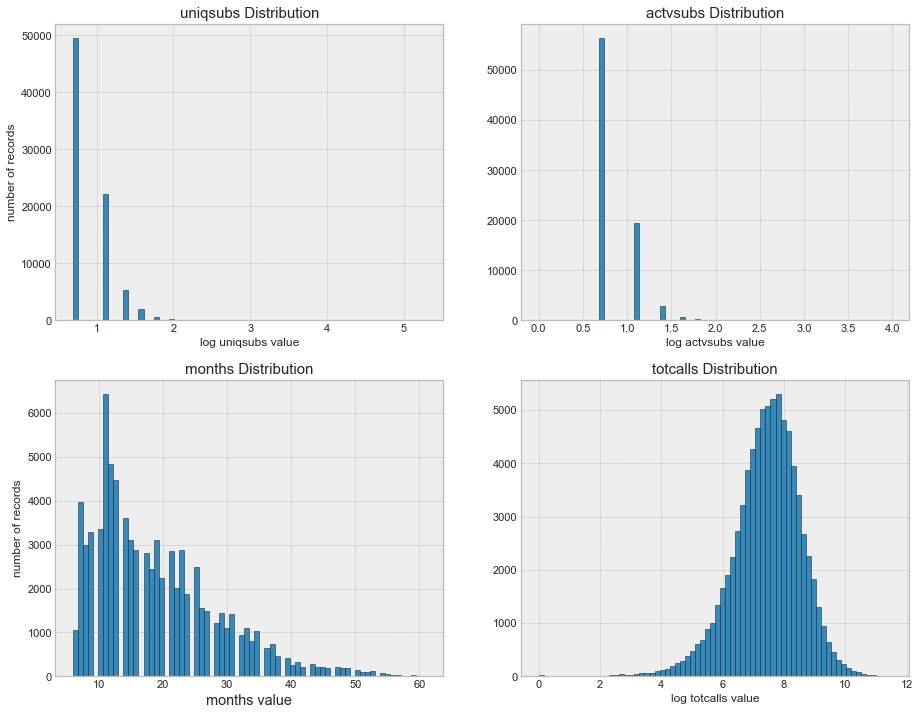

In [30]:
plot_features_dists(df_train, ['uniqsubs', 'actvsubs', 'months', 'totcalls'],
                    log={'uniqsubs':np.log1p, 'actvsubs':np.log1p, 'totcalls':np.log1p})

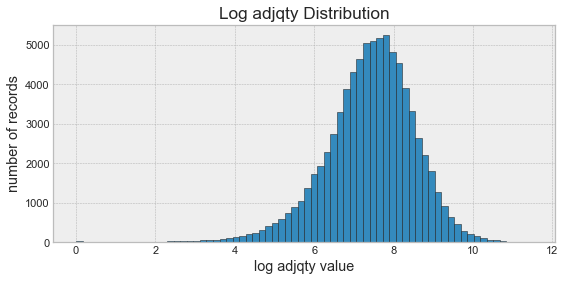

In [31]:
plot_features_dists(df_train, ['adjqty'], log=True)

Такие признаки как `totcalls`, `months`, `adjqty`, `uniqsubs`, `actvsubs`, `numbcars` совершенно однозначно являются количественными. Другие -- `adults`, `phones`, `models` сложно отнести к какой-либо категории признаков, но я сделаю предположение об их количественной природе (например, `phones` может определять число привязанных телефонов к аккаунту социальной сети).

Рассмотрим оставшиеся признаки.

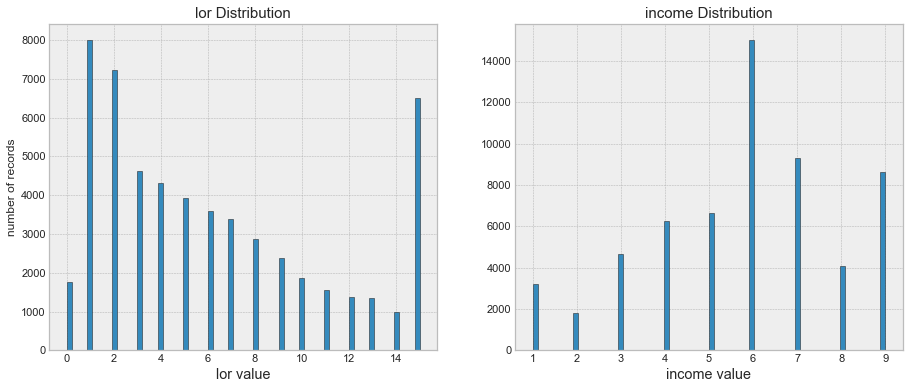

In [32]:
plot_features_dists(df_train, ['lor', 'income'], log=False)

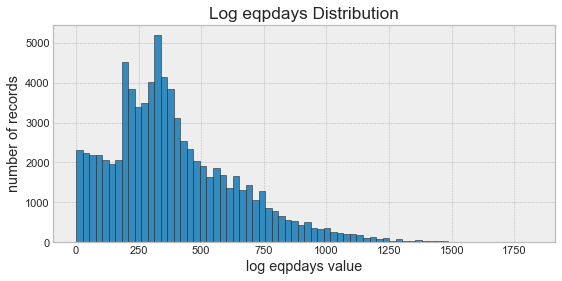

In [33]:
plot_features_dists(df_train, ['eqpdays'], log=False)

`eqpdays` -- числовой признак, `income` -- категориальный. Так, этот признак может показывать уровень дохода, однако числовым его считать не стоит, потому что количественная разница междe его значениями 2 и 4 может не быть такой же, как между 6 и 8 -- это важное свойство именно количественных признаков.

В теории `lor` может быть категориальным признаком, но на графике явно прослеживается дискретное распределение, поэтому относим его к числовым.

Логарифмируем некоторые признаки.

In [34]:
tolog = ['avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'totcalls', 'adjqty']
for feature in tolog:
    df_train['log1p_' + feature] = np.log1p(df_train[feature])
    df_test['log1p_' + feature] = np.log1p(df_test[feature])

In [35]:
ints = ['months', 'uniqsubs', 'actvsubs', 'phones', 'models',
        'lor', 'adults', 'numbcars', 'eqpdays']
cat = cats + ['income']
df_train.drop(columns=['totcalls'], inplace=True)
df_test.drop(columns=['totcalls'], inplace=True)
del cats, tmp_df, trunc_ints

## Исследование вещественнозначных признаков

### Очистка выборки от неинформативных признаков

Непрерывных признаков довольно много, и первое, что стоит сделать -- отбросить неинформативные признаки. Неинформативным признаком назовем такой столбец таблицы, в котором наиболее встречаемое значение имеет высокую пороговую долю (например, 90%). Иными словами, если 90% столбца занято одним значением, то соответствующий признак считается неинформативным.

Получим список признаков, в которых меньше 0.5% пропусков, и одно значение встречается с частотой свыше 90%, а также тех, где суммарная доля пропусков и частовстречаемых значений свыше 90%.

In [36]:
useless_features = []

for feature in floats:
    values = df_train[feature]
    counts = values.value_counts()
    most_freq = counts.iloc[0] / len(df_train)
    nans = values.isnull().mean(axis=0)
    if most_freq > 0.9 and nans < 0.005 or nans + most_freq > 0.9:
        useless_features.append(feature)
        print('{}: {:.2f}%;\tNaNs: {:.2f}%'.format(feature, most_freq * 100, nans * 100))

blck_dat_Mean: 98.78%;	NaNs: 0.00%
callfwdv_Mean: 99.55%;	NaNs: 0.00%
drop_dat_Mean: 97.37%;	NaNs: 0.00%
mou_opkd_Mean: 90.33%;	NaNs: 0.00%
mou_pead_Mean: 90.98%;	NaNs: 0.00%
opk_dat_Mean: 90.34%;	NaNs: 0.00%
peak_dat_Mean: 90.97%;	NaNs: 0.00%
recv_sms_Mean: 99.12%;	NaNs: 0.00%
unan_dat_Mean: 96.89%;	NaNs: 0.00%


Удалим эти признаки.

In [37]:
df_train.drop(columns=useless_features, inplace=True)
df_test.drop(columns=useless_features, inplace=True)
trunc_floats = [feat for feat in floats if feat not in useless_features]
len(trunc_floats)

47

Мы все равно имеем довольно много признаков, поэтому предлагается разделить их на две категории: усредненные ('Mean' в названии) и прочие.

In [38]:
mean_floats, other = [], []
for feature in trunc_floats:
    if 'Mean' in feature:
        mean_floats += [feature]
    else:
        other += [feature]
len(mean_floats), len(other)

(37, 10)

In [39]:
del floats, trunc_floats, useless_features

### Исследование усредненных статистик

Исследуем распределения оставшихся непрерывных признаков.

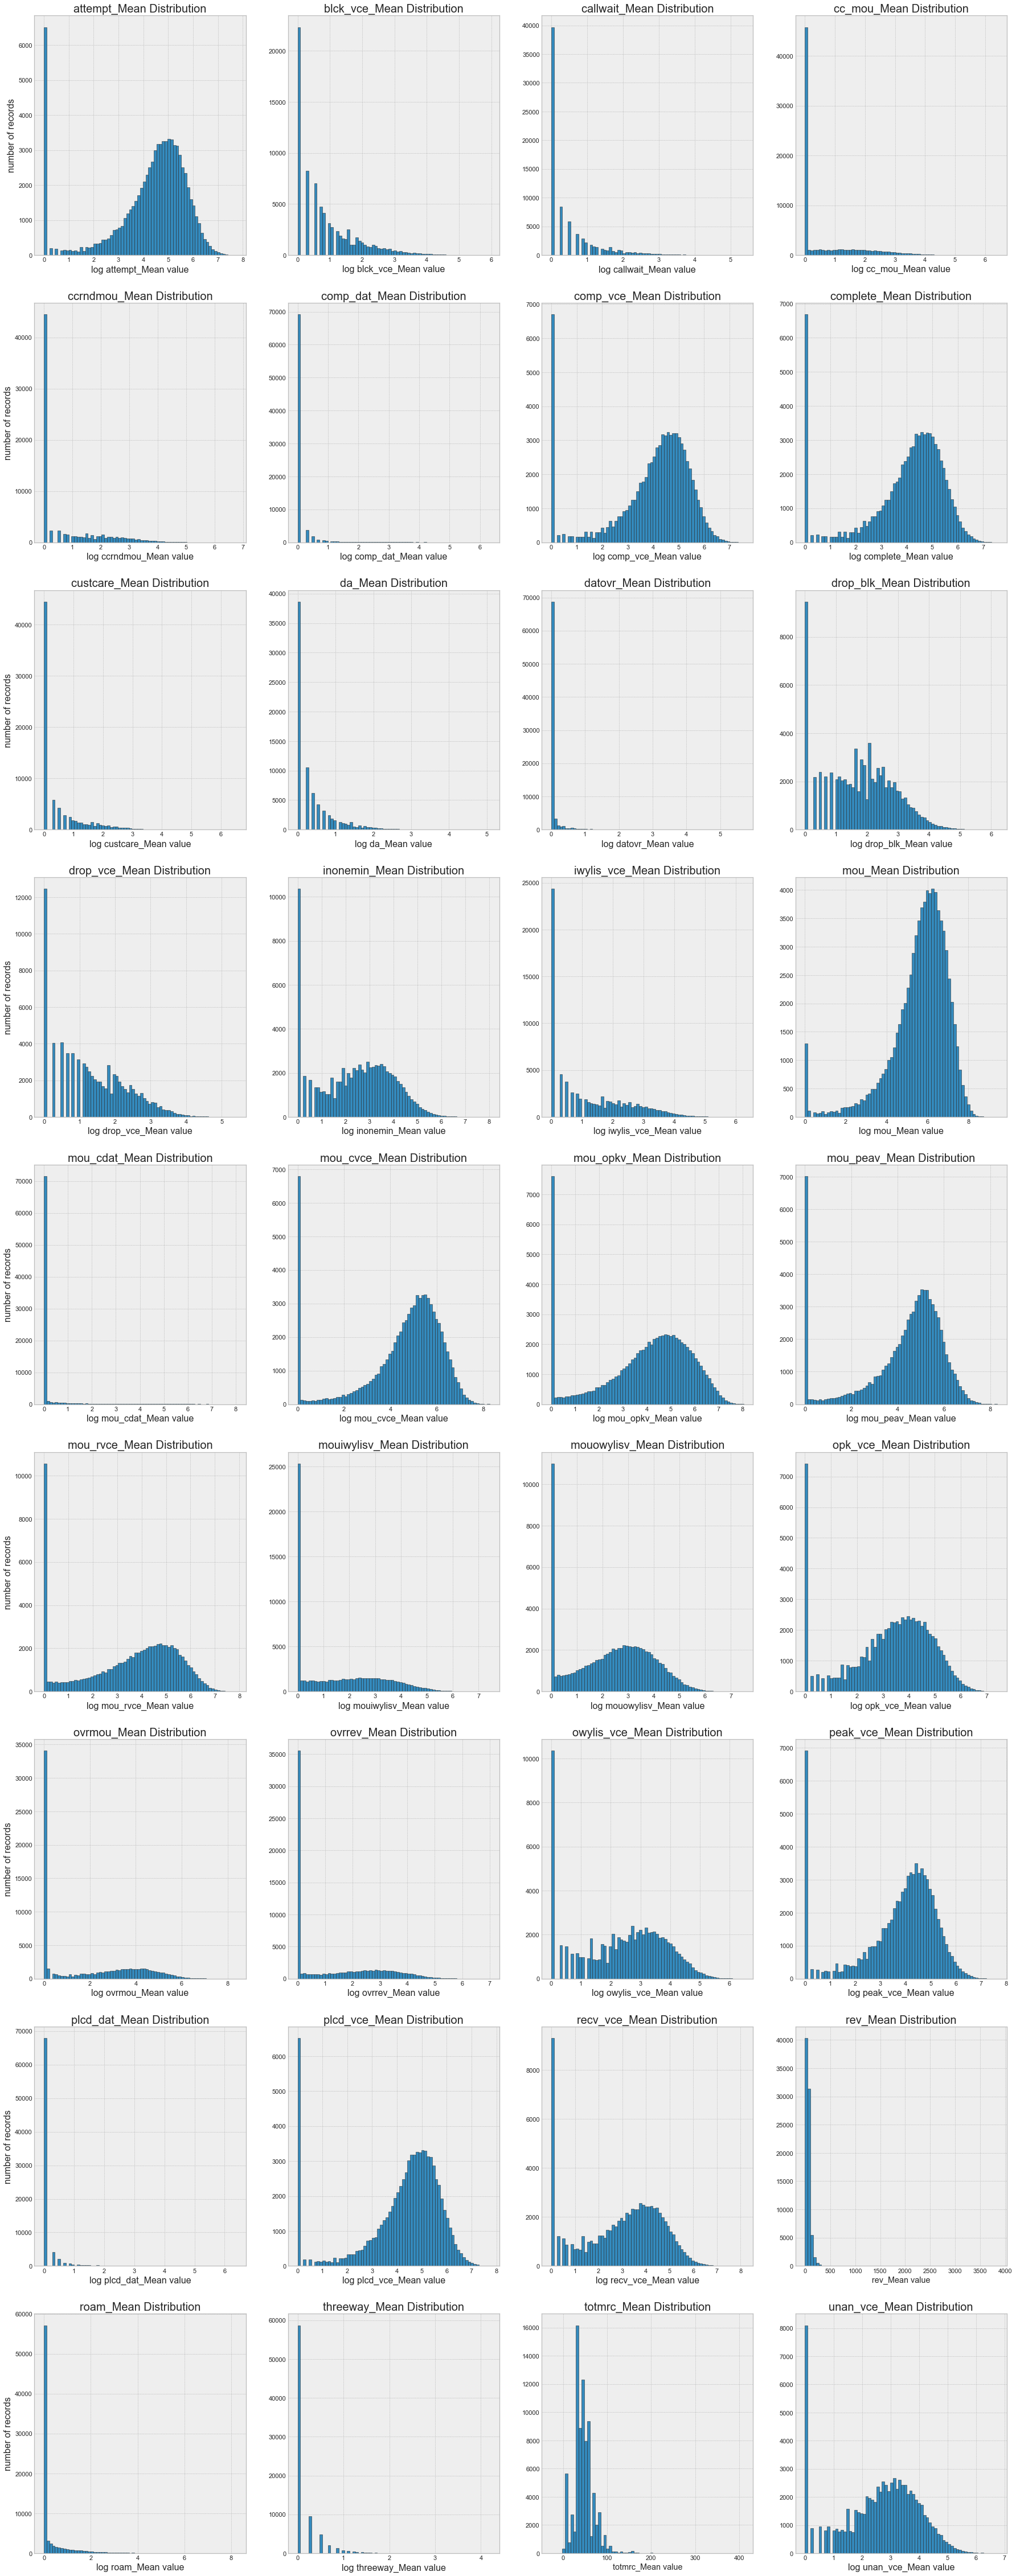

In [40]:
# Большинство непрерывных распределений здесь -- с тяжелыми хвостами, поэтому логарифмирую
unlogged_1 = plot_features_dists(df_train, mean_floats[:36], log=True, div=4)

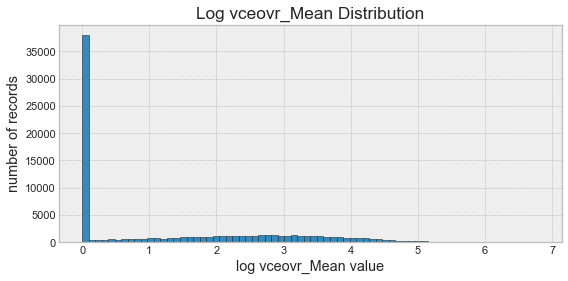

In [41]:
unlogged_2 = plot_features_dists(df_train, [mean_floats[-1]], log=True)

Заметим, что почти во всех этих признаках существуют значения, доля которых доходит до 70%, и эти значения -- нулевые. Здесь на мой взгляд нет четкой стратегии работы с такими признаками. Нулевые значения можно обработать как пропуски, заполнив их, но это может быть не совсем правильно, ведь нулевое значение может быть конкретным значением статистики, что в конечном итоге окажется важным свойством данных. Тем не менее, я затрону эту тему в одном из следующих разделах, посвященному обработке пропусков и объясню, почему такой подход на самом деле имеет место быть.

Кроме того, некоторые признаки имеют похожие распределения.

Посмотрим на остальные признаки.

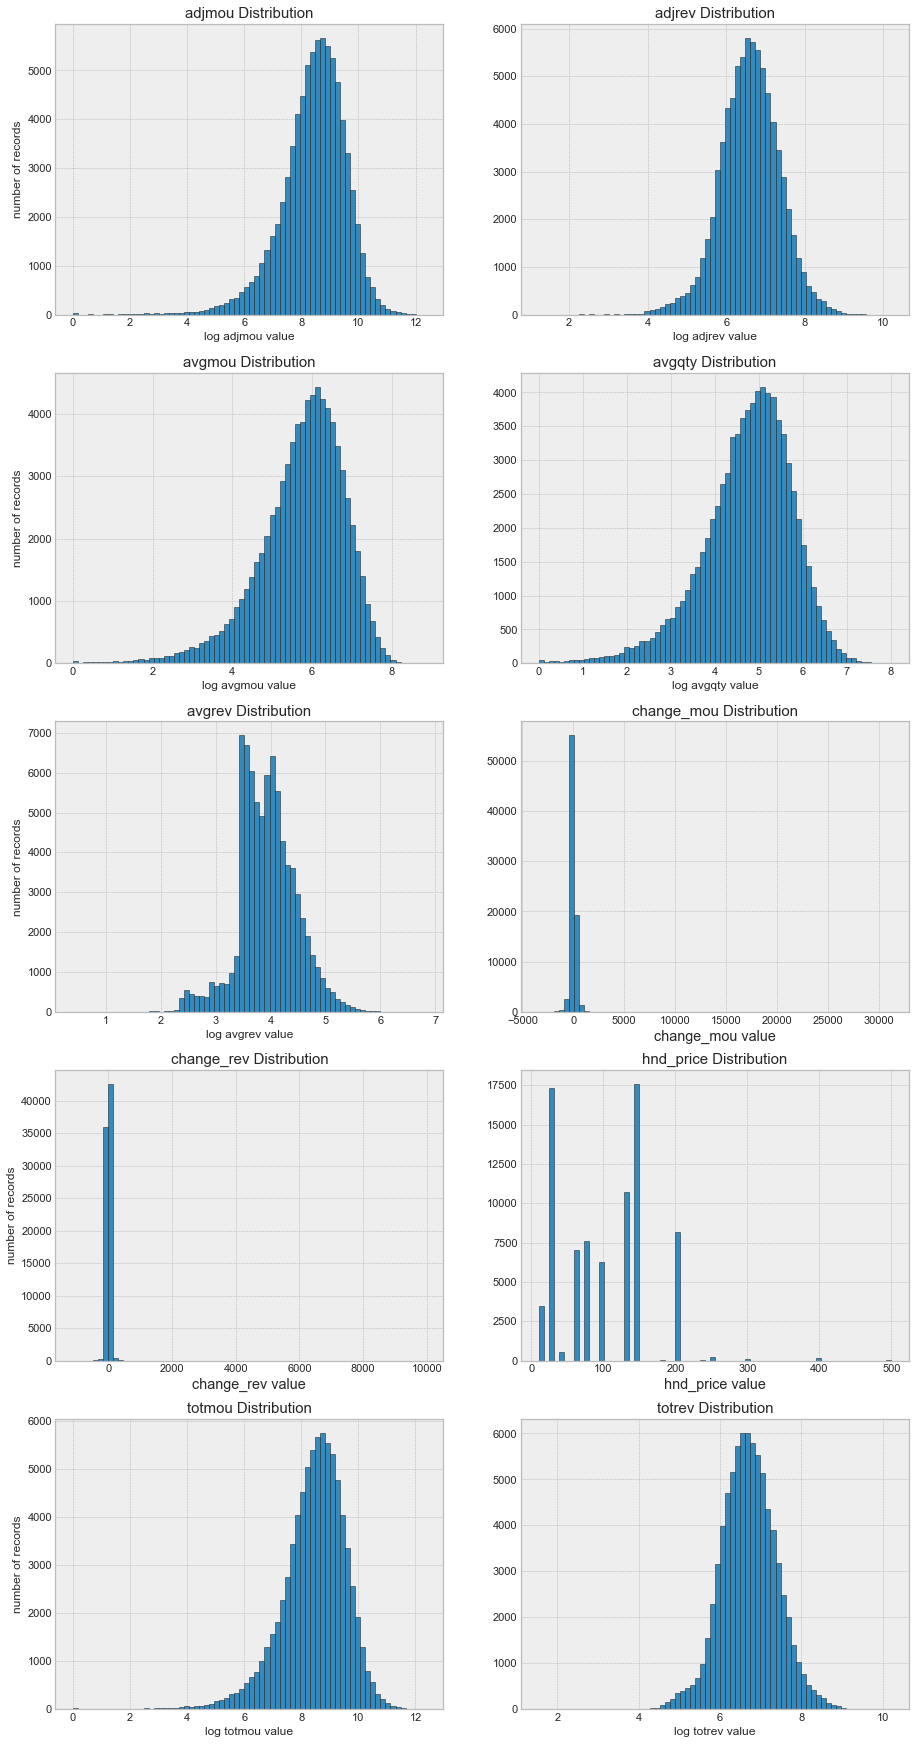

In [42]:
plot_features_dists(df_train, other,
                                 log={'adjmou':np.log1p, 'adjrev':np.log1p, 'avgmou':np.log1p, 'avgqty':np.log1p,
                                     'avgrev':np.log1p, 'totmou':np.log1p, 'totrev':np.log1p})

Заметна интересная картина: некоторые признаки практически идеально подходят под логнормальное распределение или очень близки к нему. Кроме того, здесь имеются родственные признаками с теми, которые уже были рассмотрены, а именно `avg%dmou`, `avg%drev` и др. Вероятно, эти признаки описывают схожую статистику, но уже за все время существования объекта исследования (социальной сети, мобильного оператора и т.д.).

Посмотрим на другие признаки, которые имеют достаточно странное распределение: `change_mou`, `change_rev`, `hnd_price`.

In [43]:
strange_df = df_train[['change_mou', 'change_rev', 'hnd_price']]
strange_df.describe()

,change_mou,change_rev,hnd_price
count,79258.000000,79258.000000,79333.000000
mean,-13.906472,-1.053964,101.890209
std,279.020836,52.064652,61.016061
min,-3406.500000,-1107.740000,9.989998
25%,-86.750000,-7.417500,29.989990
50%,-6.500000,-0.315000,99.989990
75%,63.250000,1.625000,149.989990
max,31219.250000,9963.657500,499.989990


Признаки `change_mou` и `change_rev` имеют выбросы: разница между третьей квантилью и максимумом слишком большая. Посмотрим на другие квантили.

In [44]:
q_99_mou, q_99_rev = strange_df.change_mou.quantile(0.99), strange_df.change_rev.quantile(0.99)
q_99_mou, q_99_rev

(737.7874999999913, 122.67257499999964)

In [45]:
q_5_mou, q_5_rev = strange_df.change_mou.quantile(0.05), strange_df.change_rev.quantile(0.05)
q_5_mou, q_5_rev

(-389.0374999999999, -48.16299999999999)

In [46]:
q_2_mou, q_2_rev = strange_df.change_mou.quantile(0.02), strange_df.change_rev.quantile(0.02)
q_2_mou, q_2_rev

(-628.75, -77.97325)

In [47]:
q_1_mou, q_1_rev = strange_df.change_mou.quantile(0.01), strange_df.change_rev.quantile(0.01)
q_1_mou, q_1_rev

(-834.9649999999999, -104.1279)

Удалим объекты, значение этих признаков в которых выше квантили 0.99. В малых квантилях все в пределах нормы.

In [48]:
df_train.drop(df_train[df_train.change_mou > q_99_mou].index, inplace=True)
df_train.drop(df_train[df_train.change_rev > q_99_rev].index, inplace=True)

In [49]:
strange_df.nunique()

change_mou     7184
change_rev    28482
hnd_price        17
dtype: int64

Похоже, что признак `hnd_price` нужно кодировать как категориальный.

In [50]:
strange_df.hnd_price.unique()

array([149.9899902 ,   9.98999786,  79.98999023,  29.98999023,
       129.9899902 , 199.9899902 ,  39.98999023,  59.98999023,
        99.98999023, 249.9899902 , 179.9899902 , 399.9899902 ,
                nan, 299.9899902 , 499.9899902 , 159.9899902 ,
       239.9899902 , 119.9899902 ])

In [51]:
strange_df.hnd_price.value_counts()

149.989990    17587
29.989990     17318
129.989990    10735
199.989990     8167
79.989990      7629
59.989990      7045
99.989990      6277
9.989998       3474
39.989990       519
249.989990      201
399.989990      158
299.989990       76
179.989990       58
499.989990       52
239.989990       34
159.989990        2
119.989990        1
Name: hnd_price, dtype: int64

Округлим до ближайшего целого. Признак может в целом можно кодировать как категориальный (например, подразумевая какой-то определенный пакет услуг), но правильнее будет отнести его к числовым.

In [52]:
df_train.hnd_price = np.round(df_train.hnd_price)
df_test.hnd_price = np.round(df_test.hnd_price)
ints += ['hnd_price']

### Исследование мультиколлинеарности

Выше мы обнаружили, что распределения некоторых признаков крайне похожи, что может повлечь за собой проблему мультиколлинеарности. Наша задача сейчас -- исследовать признаки на наличие мультиколлинеарности.

Для начала выведем попарные корреляции значением свыше 0.9 этих признаков.

In [53]:
def get_most_corred(features, corr_val=0.9):
    df_corr = df_train[features].corr()
    c = df_corr.copy()
    c.values[np.tril_indices_from(c)] = np.nan
    c_np = c.to_numpy()

    most_corred = [(c.index[i], c.columns[j], c_np[i, j])
                       for i, j in np.argwhere(c_np > corr_val)]
    return most_corred

In [54]:
most_corred_means = get_most_corred(mean_floats)
most_corred_means

[('attempt_Mean', 'comp_vce_Mean', 0.9837325646665761),
 ('attempt_Mean', 'complete_Mean', 0.9852348524304059),
 ('attempt_Mean', 'plcd_vce_Mean', 0.9984513956907047),
 ('cc_mou_Mean', 'ccrndmou_Mean', 0.9885342869510475),
 ('comp_dat_Mean', 'plcd_dat_Mean', 0.9782154458114374),
 ('comp_vce_Mean', 'complete_Mean', 0.9977632537498027),
 ('comp_vce_Mean', 'peak_vce_Mean', 0.9079029642503632),
 ('comp_vce_Mean', 'plcd_vce_Mean', 0.9852142328161917),
 ('complete_Mean', 'peak_vce_Mean', 0.9047452692891363),
 ('complete_Mean', 'plcd_vce_Mean', 0.983076365709123),
 ('inonemin_Mean', 'recv_vce_Mean', 0.9658483938645203),
 ('ovrmou_Mean', 'ovrrev_Mean', 0.9573407160471993),
 ('ovrmou_Mean', 'vceovr_Mean', 0.955773376120626),
 ('ovrrev_Mean', 'vceovr_Mean', 0.99643378239638)]

В этих признаках вероятнее всего и встречается мультиколлинеарность. Простой корреляции недостаточно, поэтому исследуем показатель `VIF`:

$$VIF_j = \frac{1}{1 - R_j^2},$$

где $R_j^2$ -- коэффициент детерминации фактора (регрессора) на другие факторы. Если показатель высок, то имеется мультиколлинеарность относительно регрессора $j$.

Несмотря на задачу бинарный классификации, в этом случае регрессионный анализ уместен (комментарий моего лектора по прикладной статистике). Иными словами, для определения мультиколлинеарности можно рассматривать задачу бинарной классификации как задачу регрессии.

In [55]:
def get_vifs(most_corred):
    to_ols = []
    for elem in most_corred:
        if elem[0] not in to_ols:
            to_ols += [elem[0]]
        if elem[1] not in to_ols:
            to_ols += [elem[1]]

    df_ols = df_train[to_ols].dropna() # | set(['churn'])
    X = add_constant(df_ols)

    vifs = {}
    for i in range(df_ols.shape[1]):
        try:
            vifs[df_ols.columns[i]] = vif(X.values, i)
        except RuntimeWarning:
            vifs[df_ols.columns[i]] = np.inf
    
    return to_ols, vifs

def validate_features(vifs, vif_treshold=300):
    bad_features = set()
    for key in vifs:
        if vifs[key] > vif_treshold:
            bad_features |= set([key])
    return bad_features

In [56]:
to_ols_means, vifs_means = get_vifs(most_corred_means)
vifs_means

{'attempt_Mean': 1.9438303131068873,
 'comp_vce_Mean': 30429727211962.812,
 'complete_Mean': 36614631116833.305,
 'plcd_vce_Mean': 63430980667190.086,
 'cc_mou_Mean': 10461323176238.086,
 'ccrndmou_Mean': 45.16934446509899,
 'comp_dat_Mean': 46.35813799270505,
 'plcd_dat_Mean': 32054089874523.1,
 'peak_vce_Mean': 95821268667457.36,
 'inonemin_Mean': 8.256697130222925,
 'recv_vce_Mean': 18.973027354351224,
 'ovrmou_Mean': 26.66276709234803,
 'ovrrev_Mean': 13.444355295773956,
 'vceovr_Mean': 180.03927081130846}

In [57]:
bad_features_means = validate_features(vifs_means, vif_treshold=200)
bad_features_means

{'cc_mou_Mean',
 'comp_vce_Mean',
 'complete_Mean',
 'peak_vce_Mean',
 'plcd_dat_Mean',
 'plcd_vce_Mean'}

Мультиколлинеарность подтверждена. Выведем тепловую карту (heatmap) для оставшихся признаков.

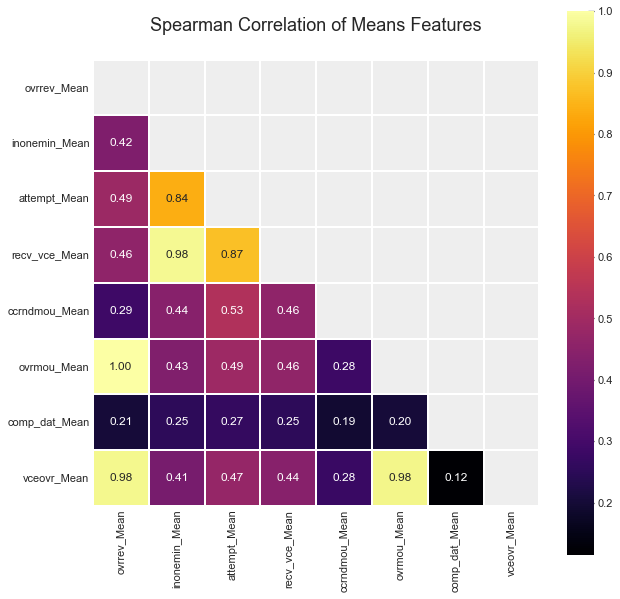

In [58]:
plot_heatmap(df_train[set(to_ols_means) - bad_features_means], _type='Means')

Аналогичную процедуру проведем и для остальных признаков.

In [59]:
# Добавляем также признаки из прошлых разделов: 'avg3mou', 'avg3qty', 'avg3rev', 'adjqty', т.д.
other += ['avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'adjqty']
most_corred_other = get_most_corred(other)
most_corred_other

[('adjmou', 'totmou', 0.9997506614054065),
 ('adjmou', 'adjqty', 0.9266974434946493),
 ('adjrev', 'totrev', 0.9984761483193673),
 ('avgmou', 'avg6mou', 0.9399077478111606),
 ('avgqty', 'avg3qty', 0.9016539156357387),
 ('avgqty', 'avg6qty', 0.9461405142620118),
 ('totmou', 'adjqty', 0.9265639314964195),
 ('avg3mou', 'avg6mou', 0.9625878003175293),
 ('avg3qty', 'avg6qty', 0.9678550415357802),
 ('avg3rev', 'avg6rev', 0.9111817353166907)]

In [60]:
to_ols_other, vifs_other = get_vifs(most_corred_other)
vifs_other

{'adjmou': 4.953796395661394,
 'totmou': 2455.7058858788128,
 'adjqty': 2432.6169687509573,
 'adjrev': 29.562212073648286,
 'totrev': 392.34523481053054,
 'avgmou': 393.2900658009727,
 'avg6mou': 40.64127784799983,
 'avgqty': 103.23300145234425,
 'avg3qty': 47.222227778101335,
 'avg6qty': 54.408888428084985,
 'avg3mou': 101.64478341216738,
 'avg3rev': 55.02155633294185,
 'avg6rev': 9.638934851491067}

In [61]:
bad_features_other = validate_features(vifs_other, vif_treshold=300)
bad_features_other

{'adjqty', 'avgmou', 'totmou', 'totrev'}

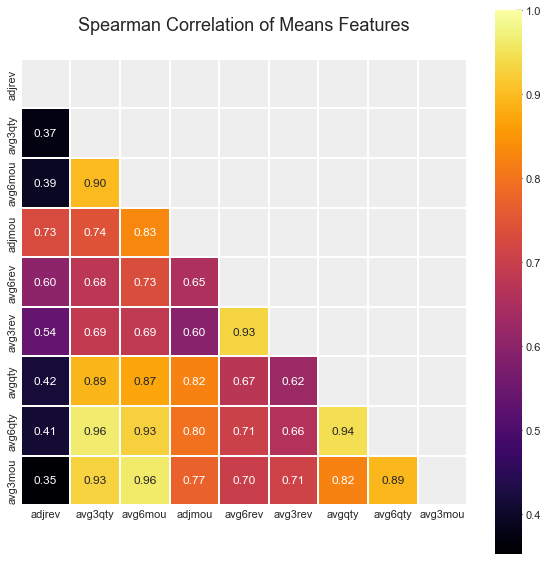

In [62]:
plot_heatmap(df_train[set(to_ols_other) - bad_features_other], _type='Means')

Итак, были исследованы различные признаки, найден новый категориальный, удалены плохие.

In [63]:
mean_floats = set(mean_floats) - bad_features_means
other = set(other) - bad_features_other - set(['hnd_price'])
len(mean_floats), len(other)

(31, 12)

Посмотрим, какие признаки из средних не удалось логарифмировать.

In [64]:
unlogged_1

{'rev_Mean': -6.1675, 'totmrc_Mean': -26.915}

In [65]:
'rev_Mean' in mean_floats, 'totmrc_Mean' in mean_floats

(True, True)

Посмотрим на их малые квантили, чтобы понять, являются ли эти значения выбросами.

In [66]:
df_train.rev_Mean.quantile(0.001), df_train.totmrc_Mean.quantile(0.001)

(3.5, 0.0)

In [67]:
df_train.rev_Mean.quantile(0.0001), df_train.totmrc_Mean.quantile(0.0001)

(0.0, -2.1173386663853977)

Да, похоже на выбросы. Занулим эти значения и тоже логарифмируем.

In [68]:
new_num_features = []

In [69]:
df_train.loc[df_train.rev_Mean < 0, 'rev_Mean'] = 0.0
df_train.loc[df_train.totmrc_Mean < 0, 'totmrc_Mean'] = 0.0
df_test.loc[df_test.rev_Mean < 0, 'rev_Mean'] = 0.0
df_test.loc[df_test.totmrc_Mean < 0, 'totmrc_Mean'] = 0.0

In [70]:
for feature in mean_floats:
    new_num_features += ['log1p_' + feature]
    df_train['log1p_' + feature] = np.log1p(df_train[feature])
    df_test['log1p_' + feature] = np.log1p(df_test[feature])

Добавляем остальные.

In [71]:
other_unlogged = ['change_mou', 'change_rev']
if other_unlogged[0] in other:
    new_num_features += [other_unlogged[0]]
if other_unlogged[1] in other:
    new_num_features += [other_unlogged[1]]

In [72]:
logged_old = ['log1p_totcalls', 'log1p_avg3mou', 'log1p_avg3qty', 'log1p_avg3rev', 'log1p_adjqty',
           'log1p_avg36mou_abs_diff', 'log1p_avg36rev_abs_diff', 'log1p_avg36qty_abs_diff']

for feature in logged_old:
    new_num_features += [feature]
    df_train[feature]
    df_test[feature]

In [73]:
other -= set(['avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'adjqty'])
other -= set(other_unlogged)

for feature in other:
    new_num_features += ['log1p_' + feature]
    df_train['log1p_' + feature] = np.log1p(df_train[feature])
    df_test['log1p_' + feature] = np.log1p(df_test[feature])

Не забудем про целочисленные признаки.

In [74]:
ints

['months',
 'uniqsubs',
 'actvsubs',
 'phones',
 'models',
 'lor',
 'adults',
 'numbcars',
 'eqpdays',
 'hnd_price']

Всего признаков стало:

In [75]:
len(new_num_features + binary + cat + ints)

80

Создаем новую таблицу с этими признаками:

In [76]:
new_df_train = df_train[new_num_features].astype(float)
new_df_test = df_test[new_num_features].astype(float)

In [77]:
len(new_num_features) == new_df_train.shape[1]

True

In [78]:
# float 'cause NaN
new_df_train[ints] = df_train[ints].astype(float)
new_df_test[ints] = df_test[ints].astype(float)

In [79]:
len(new_num_features) + len(ints) == new_df_train.shape[1]

True

In [80]:
new_df_train[binary] = df_train[binary].astype(object)
new_df_test[binary] = df_test[binary].astype(object)

In [81]:
len(new_num_features) + len(ints) + len(binary) == new_df_train.shape[1]

True

In [82]:
new_df_train[cat] = df_train[cat].astype(object)
new_df_test[cat] = df_test[cat].astype(object)
len(new_num_features) + len(ints) + len(binary) + len(cat) == new_df_train.shape[1]

True

In [83]:
new_df_train['churn'] = df_train['churn']
new_df_test['churn'] = df_test['churn']

**Итак, на данный момент признаки были поделены на категории, по категориям количественных и категориальных признаков был проведен анализ распределений, частично обнаружены и исправлены выбросы, установлена и решена проблема мультиколлинеарности, проведен первичный отбор и преобразование признаков.**

In [84]:
assert new_df_train.shape[1] == len(new_num_features) + len(ints) + len(binary) + len(cat) + 1
new_df_train.shape[1]

81

In [85]:
features_dict = {
    'float': new_num_features,
    'int': ints,
    'binary': binary,
    'categorical': cat,
    'target': 'churn',
}

In [86]:
try:
    os.mkdir('new_data')
except:
    pass

new_df_train.to_csv('new_data/df.csv', index=False)
new_df_test.to_csv('new_data/df_test.csv', index=False)

jsonStr = json.dumps(features_dict)
file = open('features_types.json', 'w')
file.write(jsonStr)
file.close()